# **<font color='708090'>Trendy</font><font color='#FF00FF' >Fashion</font><font color='blue'>Fusion</font><font color='darkblue'> Recommender</font>**

   ![trollface](https://github.githubassets.com/images/icons/emoji/trollface.png)

# **Table of Contents**

1. [Import Dependencies](#Import-Dependencies)
2. [Data Exploration](#Data-Exploration)
3. [RESNET CNN Model](#RESNET-CNN-Model)
   
   3.1. [NearestNeighbors](#NearestNeighbors)
   
4. [DenseNet121 Model](#DenseNet121-Model)

   4.1. [Cosine Similarity](#Cosine-Similarity)
   
5. [Save TensorFlow Model (Weights and Architecture)](#Save-TensorFlow-Model-(Weights-and-Architecture))
6. [API EndPoints and Communication](#API-EndPoints-and-Communication)

   6.1. [Deploying with Flask API](#Deploying-with-Flask-API)
   
5. [References](#References)
6. [Final Thoughts](#Final-Thoughts)


# **Import Dependencies**

In [90]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Packages/Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
import sklearn
import platform
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from numpy.linalg import norm 
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from keras.utils import plot_model
from keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import Sequential
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.image as mpimg
import pathlib
import os
import cv2
import pickle


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# List all files and directories under /kaggle/input
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [91]:
import sklearn
import platform  
print('Python version:', platform.python_version())
print('Scikit-learn version:',sklearn.__version__)
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

In [92]:
# Create or update the requirements.txt file with installed packages
!pip freeze > requirements.txt

# Display the content of requirements.txt
# !cat requirements.txt

# **Data Exploration**

* Dataset: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset 

In [93]:
# Defining the Path to the dataset
path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/'
dataset_path = pathlib.Path(path)
dataset_path

PosixPath('/kaggle/input/fashion-product-images-dataset/fashion-dataset')

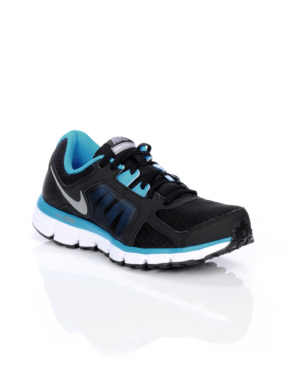

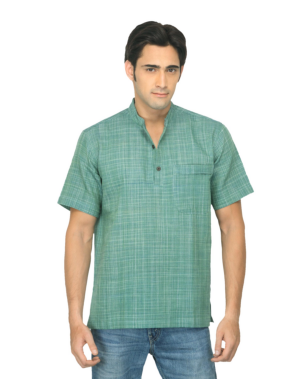

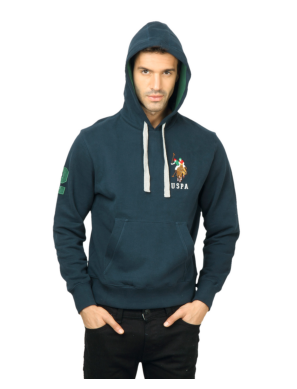

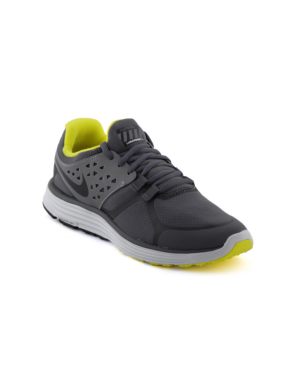

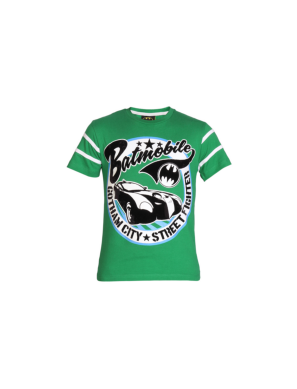

In [94]:
############################ Loading files ##############################################

csv_path = r'/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv'
images_base_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/'

# Handling parsing errors
# try:
#     # Use `on_bad_lines='skip'` to skip lines with too many fields
#     styles_df = pd.read_csv(csv_path, on_bad_lines='skip')
#     print("CSV loaded successfully.")
# except pd.errors.ParserError as e:
#     print(f"Error loading CSV: {e}")
# styles_df

print("Number of Total images:", len(os.listdir(images_base_path)))
# Function to load and display an image (first 5 for verification)
def load_and_display_image(image_filename):
    image_path = os.path.join(images_base_path, image_filename)
    try:
        with Image.open(image_path) as img:
            plt.imshow(img)
            plt.axis('off')  # Hide axis
            plt.show()
    except FileNotFoundError:
        print(f"Image not found: {image_filename}")
        
image_filenames = os.listdir(images_base_path)  # List of image files in the directory

# Displays all images from the directory
if image_filenames:
    for image_filename in image_filenames[:5]:  # Limit to the first 5 images
        load_and_display_image(image_filename)
else:
    print("No images found in the directory.")


# **RESNET CNN Model**

In [95]:
############################ Defining Model##############################################

# Generate Embeddigns using ResNet50
# ImageFile.LOAD_TRUNCATED_IMAGES = True
model=ResNet50(weights='imagenet',include_top=False, input_shape=(224,224,3))
model.trainable = False

# model = tf.keras.models.Sequential([model,
#                                    GlobalMaxPool2D()
#                                    ])
model = tensorflow.keras.Sequential([
    model,
    GlobalMaxPooling2D()
])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_5          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [96]:
# Function to extract features of images (44k here)
def extract_features(path,model):
    img=image.load_img(path, target_size=(224,224))
    img_arr=image.img_to_array(img)
    exp_img_arr=np.expand_dims(img_arr,axis=0)
    pre_pr_img=preprocess_input(exp_img_arr)
    result=model.predict(pre_pr_img).flatten()
    normal_result=result/norm(result)
    return normal_result

In [97]:
# extract_features(filenames[0], model)

In [98]:
############################## Lists for saving filenames and features #########################

# Extract Filenames from Folder
# filenames = []
# for file in os.listdir('images'):
#     # print(file)
#     # break
#     # print(os.path.join('images',file)
#     filenames.append(os.path.join('images',file))
# filenames[0]

# Extract Features from files
# feature_list = []
# for file in tqdm(filenames): # disable=True
# # for file in tqdm(filenames, desc='Processing files', bar_format='{l_bar}{bar} [elapsed: {elapsed}, {rate_fmt}]'):  # Customized bar added
#     feature_list.append(extract_features(file,model))
# feature_list

In [99]:
# Extract Filenames from Folder
filenames = [os.path.join(images_base_path,files) for files in os.listdir(images_base_path)] # images
print(f"Total number of files: {len(filenames)}")

In [100]:
# Extract Features from files
feature_list = []
for file in tqdm(filenames): # disable=True
# # for file in tqdm(filenames, desc='Processing files', bar_format='{l_bar}{bar} [elapsed: {elapsed}, {rate_fmt}]'):  # Customized bar added
    feature_list.append(extract_features(file,model))
# feature_list
print('Extraction Completed')

# It took more than 1hr to extract features of all 44441 images on GPU Accelerator

100%|██████████| 44441/44441 [1:12:56<00:00, 10.15it/s]


In [105]:
# Extract Features from files (Updated Code to handle notebook crash due to ouput)

# import os
# import sys

# Suppress output
# sys.stdout = open(os.devnull, 'w')

# # Suppress TensorFlow logs
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Only show errors, hide warnings and info
# tf.get_logger().setLevel('ERROR')  # Suppress logs in some environments

# feature_list = []
# for file in tqdm(filenames, disable=True):  # Progress bar hidden
#     feature_list.append(extract_features(file, model))

# # # Restore output
# sys.stdout = sys.__stdout__

In [106]:
############################## Export Features #########################
pickle.dump(feature_list,open('embeddings.pkl','wb'))
pickle.dump(filenames,open('filenames.pkl','wb'))

In [107]:
############################### Loading stored features and images ##################################
# feature_list=pickle.load(open(r'/kaggle/working/embeddings.pkl','rb'))
feature_list = np.array(pickle.load(open('/kaggle/working/embeddings.pkl','rb')))
filenames = pickle.load(open('/kaggle/working/filenames.pkl','rb'))

In [109]:
########################  Extract features of new query image #######################

# Load & preprocess image i.e PTL object
# img_path = '/kaggle/input/sample/istockphoto-1401823467-1024x1024.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# img_arr = image.img_to_array(img)
# # print(img_arr)

# # Expand dimensions and preprocess
# exp_img_arr = np.expand_dims(img_arr, axis=0)   # Reshape image
# pre_pr_img = preprocess_input(exp_img_arr)

# # Predict features
# res = model.predict(pre_pr_img).flatten()
# # res

# # Normalize result
# norm_res = res/norm(res)

In [115]:
def feature_extraction(path,model):
    img=image.load_img(path, target_size=(224,224))# Load image in size of 224,224,3
    img_arr=image.img_to_array(img)# storing into array
    expan_img_arr=np.expand_dims(img_arr,axis=0)## Expanding the dimension of image
    pre_pr_img=preprocess_input(expan_img_arr)## preprocessing the image
    result=model.predict(pre_pr_img).flatten()### to make 1d vector
    norm_result=result/norm(result)## Normalize the result using norm func from linalg(numpy)
    return norm_result

## **NearestNeighbors**

In [111]:
######## Train KNN to Find Similar Images

knn_model = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean')
knn_model.fit(feature_list)

NearestNeighbors(algorithm='brute', metric='euclidean')

In [181]:
img_path = '/kaggle/input/samples/saree.jpg'
input_image = feature_extraction(img_path,model)
# distances,indices = knn_model.kneighbors([norm_res])
distances,indices = knn_model.kneighbors([input_image])
# print(indices)
indices[0]

array([15361,  8446, 28648, 38912, 34151])

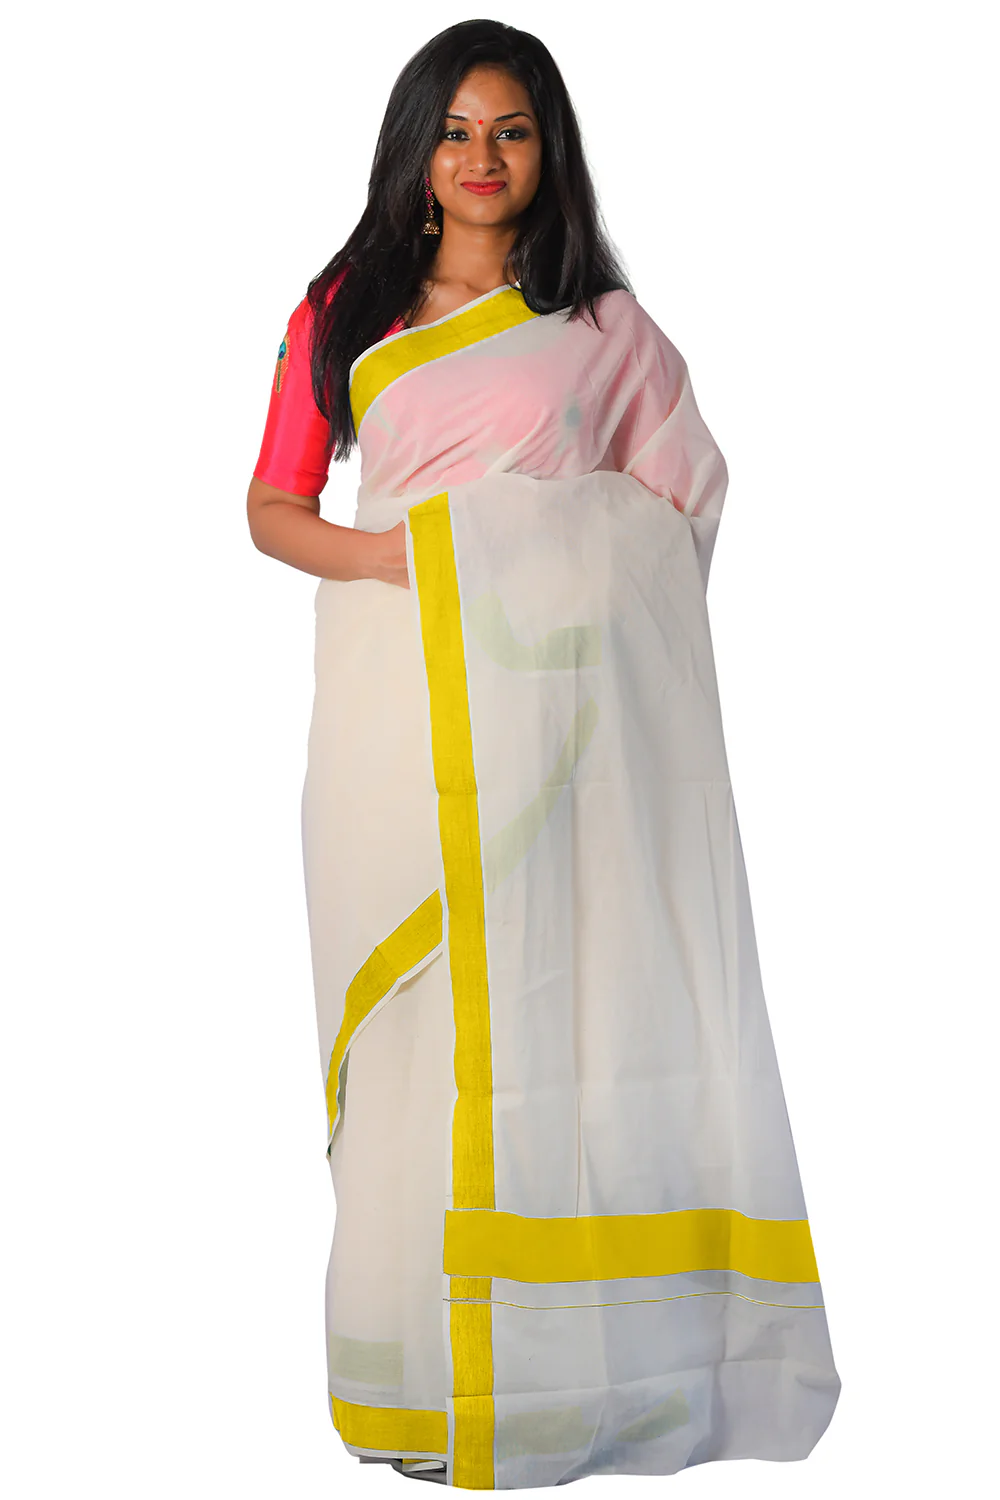

In [182]:
from IPython.display import Image
Image(img_path)

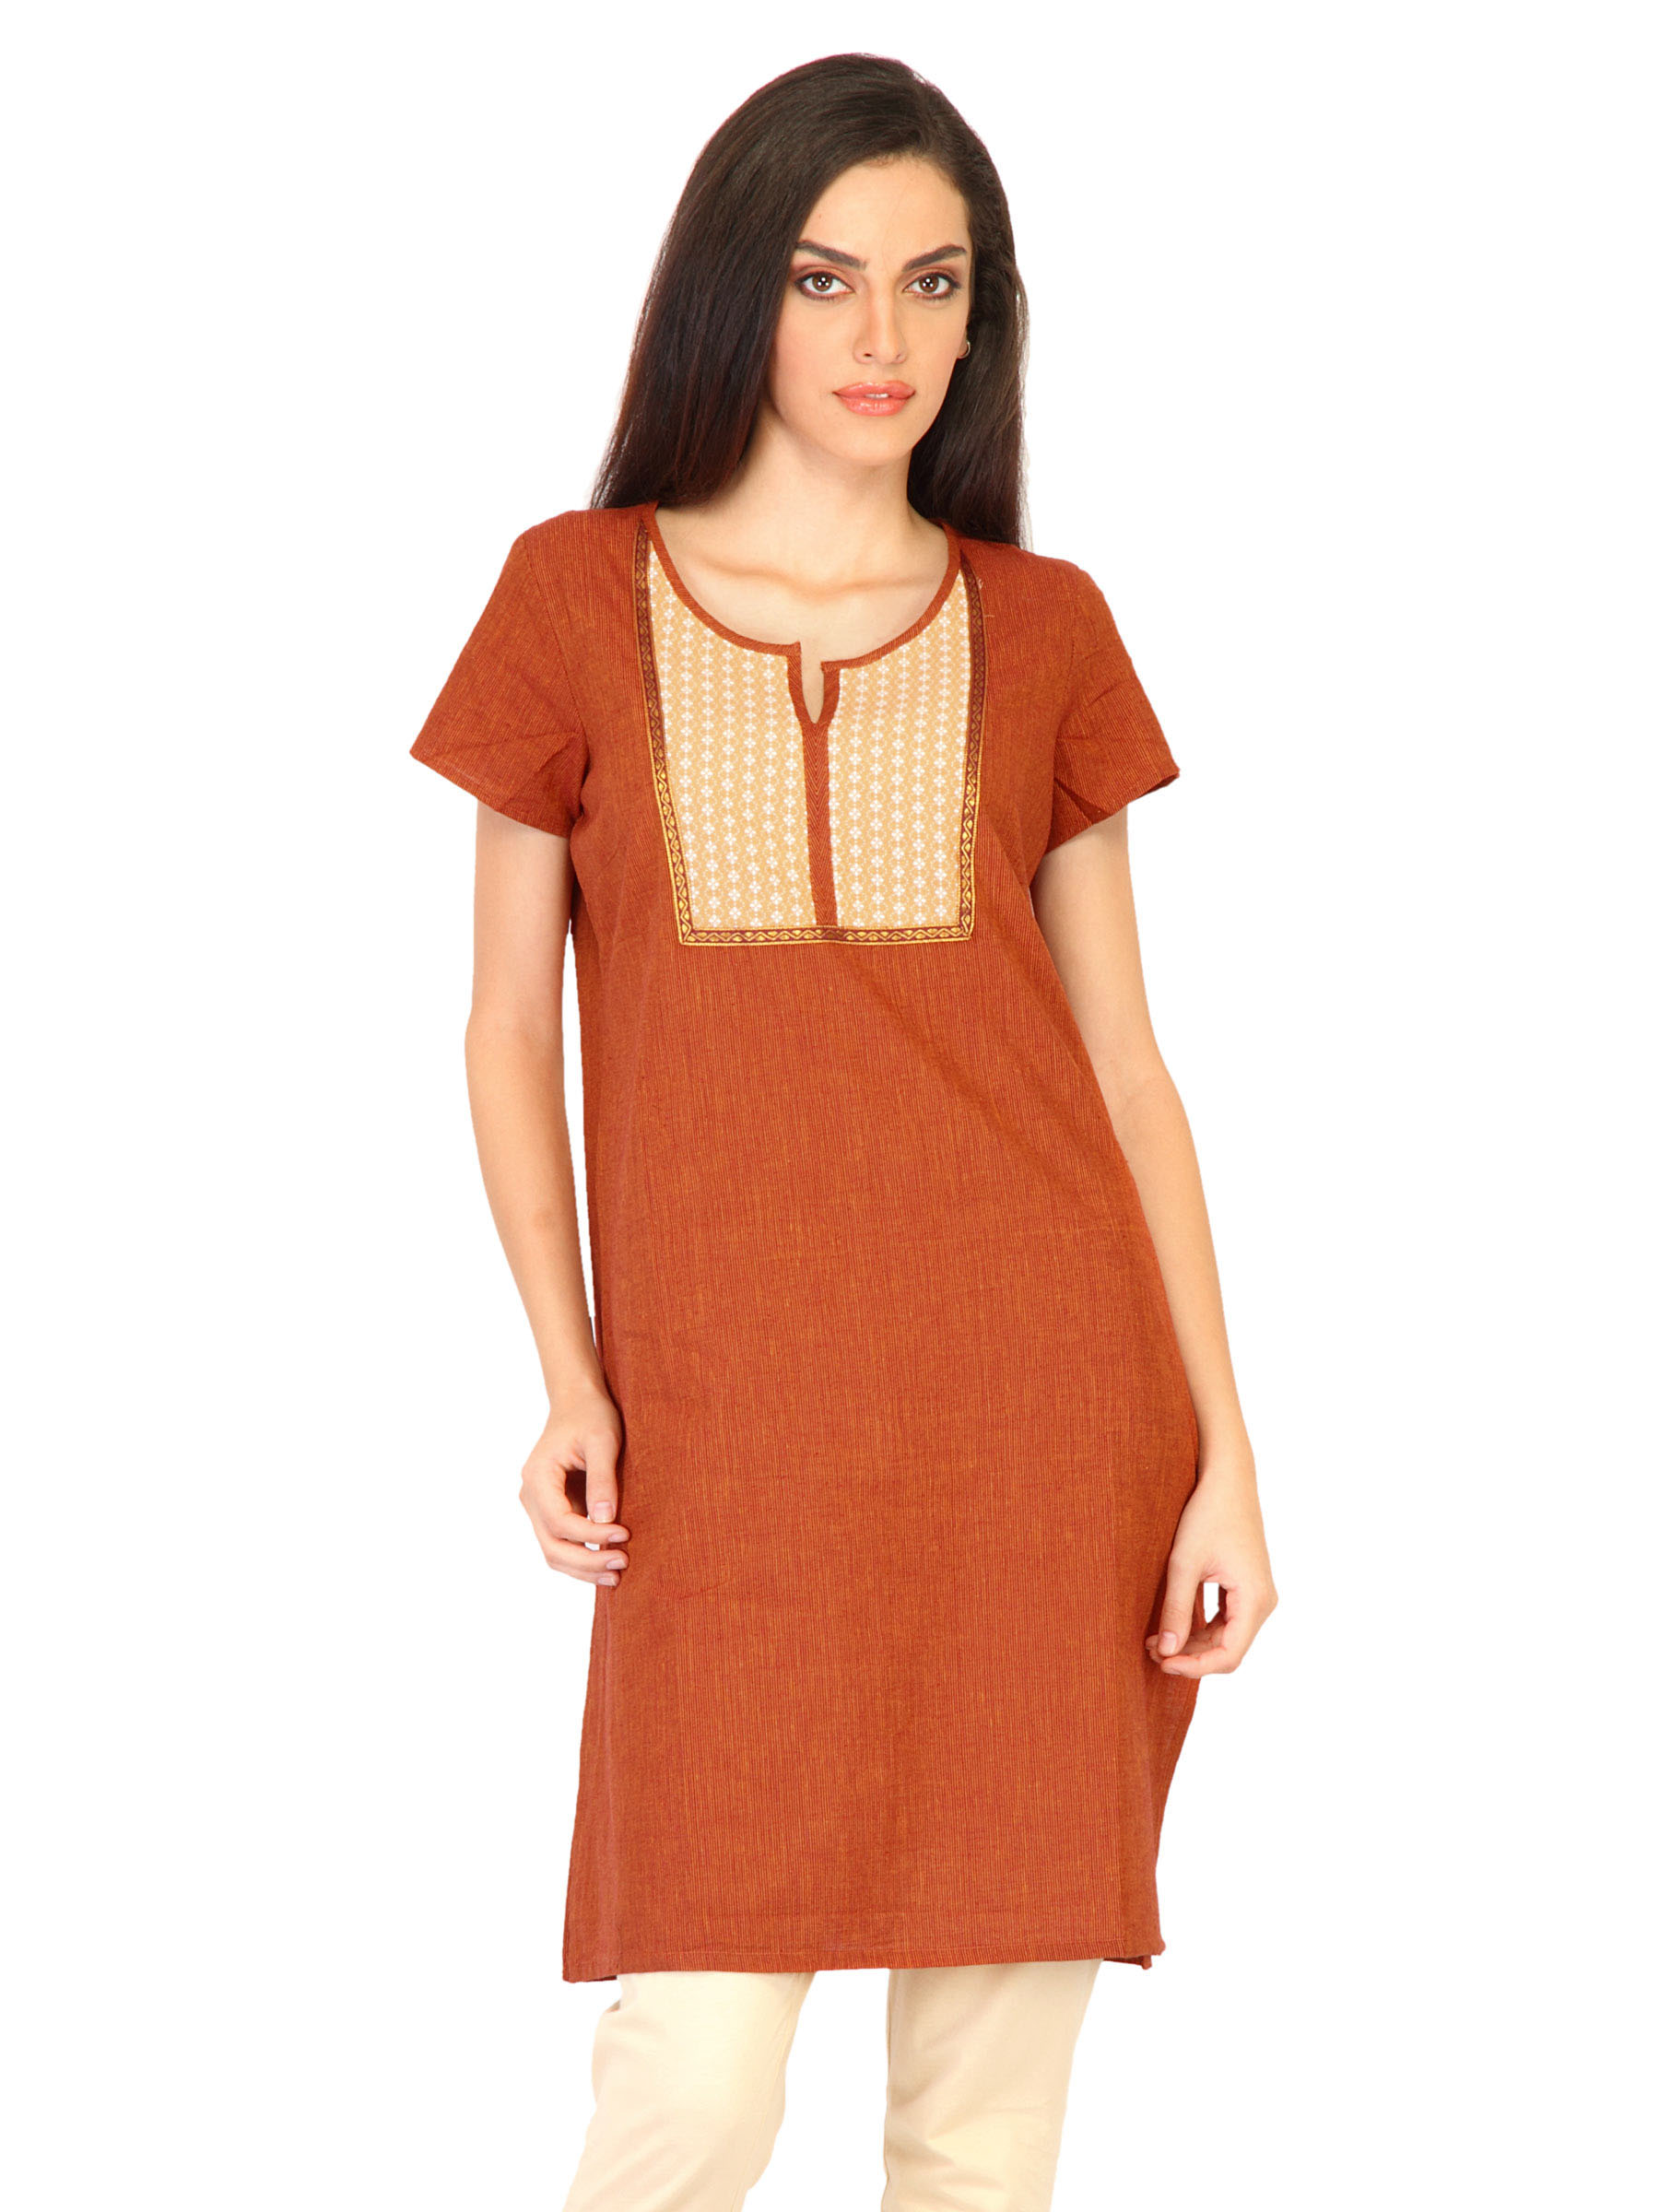

In [184]:
# Similar Images
Image(filenames[indices[0][1]]) # 1st image
Image(filenames[indices[0][2]]) # 2nd image
# ....so on

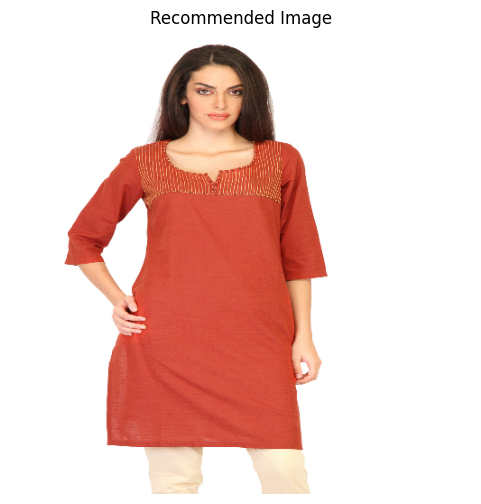

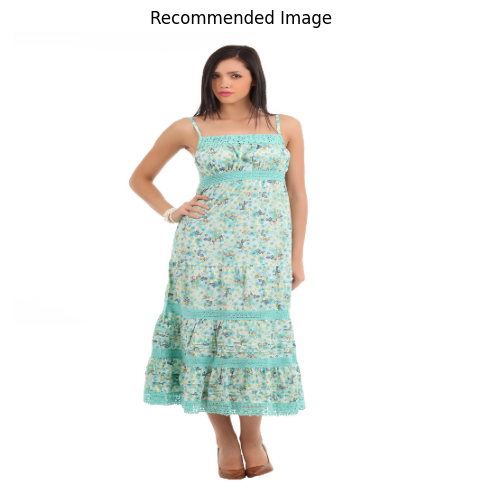

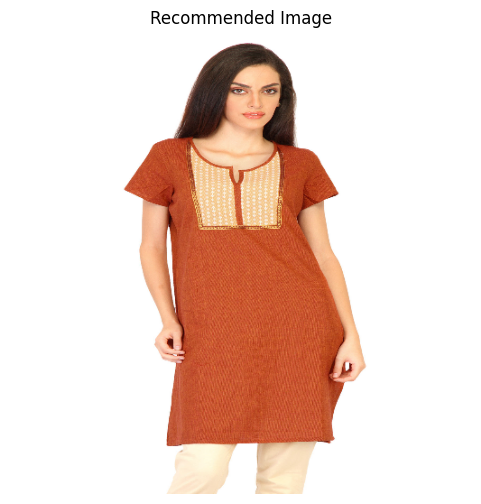

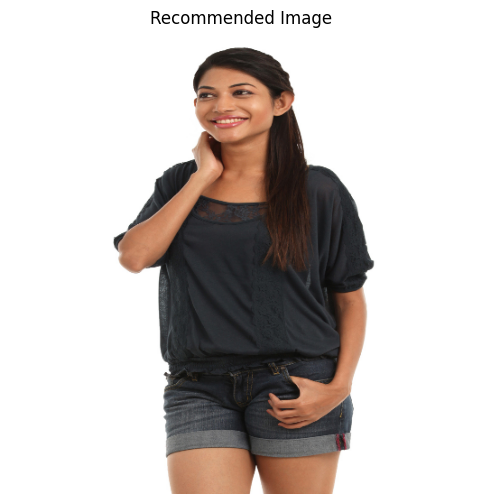

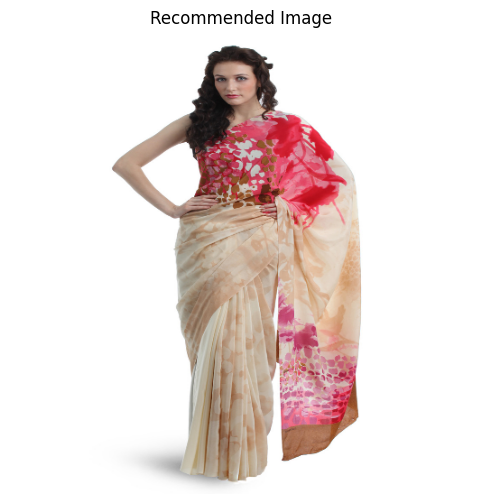

In [185]:
# Taking`filenames` and `indices`  which are defined and contain the paths and indices respectively

# Display sample images using matplotlib
for file in indices[0][0:6]:
    temp_img = cv2.imread(filenames[file])
    temp_img = cv2.resize(temp_img, (512, 512))

    # Convert BGR to RGB for display
    temp_img_rgb = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(temp_img_rgb)
    plt.title('Recommended Image')
    plt.axis('off')  # Hide axis
    plt.show()

In [ ]:
def recommend(features,feature_list):
    neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
    neighbors.fit(feature_list) # (Taking feature_list contains extracted features)

    distances, indices = neighbors.kneighbors([features])

    return indices

# **DenseNet121 Model**

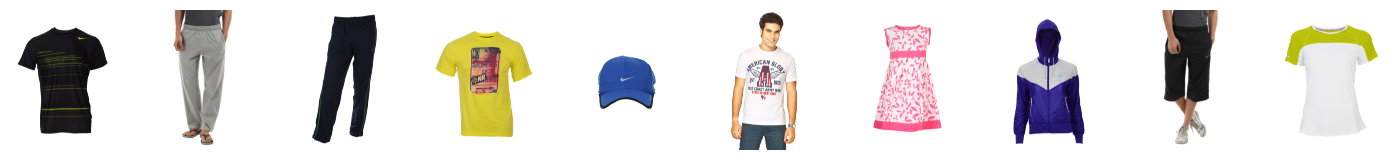

In [147]:
# Plotting the images 
plt.figure(figsize=(20, 20))
for i in range(10, 20):
    plt.subplot(6, 10, i - 10 + 1)
    cloth_img = mpimg.imread(images_base_path + '/100' + str(i) + '.jpg')
    plt.imshow(cloth_img)
    plt.axis("off")
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

**DataFrame with categories & adding column of image name**


In [186]:
# Reading the CSV file(defined), skipping bad lines
df = pd.read_csv(csv_path, nrows=6000, on_bad_lines='skip')
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [188]:
df.shape

(6000, 10)

In [189]:
# Add a column for the image filenames & Reset the index
df['image'] = df.apply(lambda x: str(x['id']) + ".jpg", axis=1).reset_index(drop=True)

df.shape

(6000, 11)

**Setup for Pre-trained Model DenseNet121**

In [194]:
# Image dimensions
img_width, img_height, channel = 200, 200, 3

# Loading DenseNet121 with pre-trained ImageNet weights, excluding the top classification layer
densenet = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_width, img_height, channel))
densenet.trainable = False   # Sets DenseNet121 layers to be non-trainable

# Creating Sequential model with addition of DenseNet121 and GlobalMaxPooling2D layers
model2 = Sequential([
    densenet,
    GlobalMaxPooling2D()
])

# Model summary for verifying the trainable parameters
model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_8          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [196]:
# Model prediction

def img_path(img):
    return images_base_path + img

# Function to predict features using the model
def model_predict(model, img_name):
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    x = image.img_to_array(img)     # img2arr
    x = np.expand_dims(x, axis=0)   # Expand Dim (1, w, h)
    x = preprocess_input(x)         # Preprocess Input
    return model.predict(x).reshape(-1)

In [199]:
# Extracting embeddings for all images in the dataset
df_copy = df.copy()
df_embedding = df_copy['image'].apply(lambda x: model_predict(model2, x))
df_embedding = pd.DataFrame(df_embedding.tolist())    # df of model prediction for all of images
df_embedding.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.002810,0.012423,0.014944,0.019022,0.243451,1.580462,0.001359,0.012418,0.944371,0.001556,...,0.853101,0.043303,5.379200,0.072366,0.086717,2.995912,3.064219,3.873226,8.095032,4.099652
1,0.000938,0.010240,0.014157,0.033368,0.232703,1.341559,0.001307,0.014866,0.515355,0.001125,...,2.026177,2.503704,11.056705,1.638562,0.518403,2.941541,0.941123,1.342537,1.992480,1.315478
2,0.001214,0.013573,0.015378,0.007322,0.364703,1.351415,0.002805,0.005552,0.648475,0.001928,...,4.141374,1.066643,1.784391,4.047669,3.761931,1.472843,1.410462,6.991835,9.101645,0.933300
3,0.001080,0.014465,0.022208,0.018075,0.293792,4.160220,0.001272,0.012537,0.477520,0.002318,...,1.129942,0.632325,10.668570,2.681414,0.326606,3.301014,0.000000,2.327764,5.492825,0.780042
4,0.001774,0.011407,0.012123,0.018447,0.337456,1.672153,0.001197,0.011453,0.505674,0.000860,...,0.718572,2.938374,10.829138,0.801260,1.382698,2.993899,1.796368,10.143229,7.059000,1.023532


## **Cosine Similarity**
Computing cosine similarity **to determine a numeric value representing the similarity between two images is straightforward and efficient to perform.

**Compute Cosine Similarity for Recommendations**


In [200]:
# Computing cosine similarity & Getting indices
cosine_sim = linear_kernel(df_embedding, df_embedding)
indices = pd.Series(range(len(df)), index=df.index)
indices[:5]

0    0
1    1
2    2
3    3
4    4
dtype: int64

**Getting recommendations using the cosine similarity**

In [227]:
# Function to get recommendations given an image path or index
def get_recommendations(index, df, cosine_sim=cosine_sim):
    idx = indices[index]

    # Get the pairwsie similarity scores of all products with that one
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[1:6]

    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['image'].iloc[cloth_indices]

# Function to show recommendations given an image path or index
def show_recommendations(input, is_path=False):
    if is_path:
        # If input is an image path, find the index
        img_name = input.split('/')[-1]
        index = df[df['image'] == img_name].index[0]
    else:
        # If input is an index
        index = input
    
    # Get recommendations
    recommendation = get_recommendations(index, df, cosine_sim)
    recommendation_list = recommendation.to_list()
    
    # Display chosen image
    plt.figure(figsize=(10, 10))
    img_path = images_base_path + df.iloc[index].image  
    selected_img = mpimg.imread(img_path)
    plt.title("Chosen image")
    plt.imshow(selected_img)
    plt.axis("off")
    plt.show()
    
    # Display recommended images
    plt.figure(figsize=(20, 20))
    for j, img_name in enumerate(recommendation_list):
        plt.subplot(6, 10, j + 1)
        recommendation_img_path = images_base_path + img_name  # Path for the recommended image
        cloth_img = mpimg.imread(recommendation_img_path)  # Correct image for each recommendation
        plt.imshow(cloth_img)

        cloth_img = mpimg.imread(img_path)
        plt.imshow(cloth_img)
        plt.axis("off")
    plt.title("Recommended images")
    plt.subplots_adjust(wspace=-0.5, hspace=1)
    plt.show()

In [231]:
# Function to get recommendations given an image path or index
def get_recommendations(index, df, cosine_sim=cosine_sim):
    idx = indices[index]

    # Get the pairwise similarity scores of all products with that one
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[1:6]

    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the images of the 5 most similar clothes
    return df['image'].iloc[cloth_indices]

# Function to show recommendations given an image path or index
def show_recommendations(input, is_path=False):
    if is_path:
        # If input is an image path, find the index
        img_name = input.split('/')[-1]
        index = df[df['image'] == img_name].index[0]
    else:
        # If input is an index
        index = input
    
    # Get recommendations
    recommendation = get_recommendations(index, df, cosine_sim)
    recommendation_list = recommendation.to_list()
    
    # Display chosen image
    plt.figure(figsize=(9, 9))
    img_path = images_base_path + df.iloc[index].image  # Path for the chosen image
    selected_img = mpimg.imread(img_path)
    plt.title("Chosen image")
    plt.imshow(selected_img)
    plt.axis("off")
    plt.show()
    
    # Display recommended images
    plt.figure(figsize=(20, 20))
    for j, img_name in enumerate(recommendation_list):
        plt.subplot(1, 5, j + 1)  # Display 5 recommended images in one row
        recommendation_img_path = images_base_path + img_name  # Path for each recommended image
        cloth_img = mpimg.imread(recommendation_img_path)  # Load the recommended image
        plt.title("Recommended images")
        plt.axis("off")
        plt.imshow(cloth_img)
    plt.subplots_adjust(wspace=0.3, hspace=2)  # Adjust spacing between images
    plt.show()


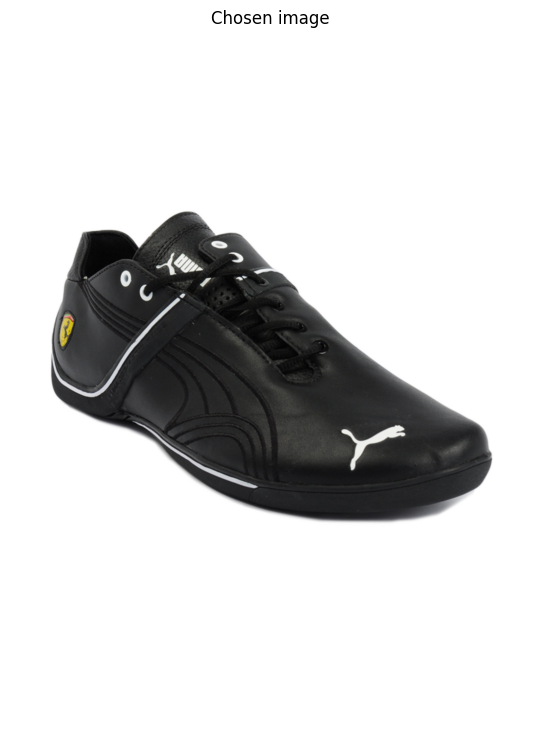

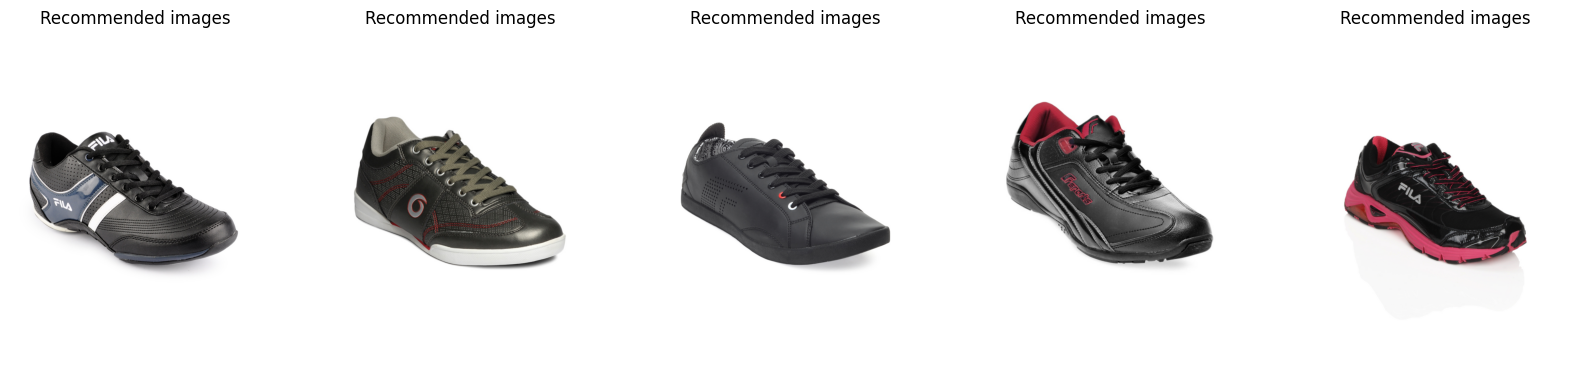

In [232]:
# Show recommendations for an image index
show_recommendations(10)

# **Save TensorFlow Model (Weights and Architecture)**

Deployment with TensorFlow and Pickle Files

ResNet50 will be loaded using TensorFlow for extracting features.

Precomputed Embeddings and filenames will be stored in Pickle files for efficient loading and querying.

In [ ]:
# TensorFlow model saving (ResNet50 for feature extraction)
model.save('/kaggle/working/resnet_model.h5')  # Save the model

In [ ]:
# Save the KNN model using pickle
pickle.dump(knn_model, open('/kaggle/working/knn_model.pkl', 'wb'))

#### **Trying Model**

In [ ]:
# Load precomputed embeddings and filenames
feature_list = np.array(pickle.load(open('embeddings.pkl', 'rb')))
filenames = pickle.load(open('filenames.pkl', 'rb'))

# Load pre-trained ResNet50 model (with GlobalMaxPooling)
model = tf.keras.models.load_model('resnet_model.h5')

# Load pre-trained KNN model
knn_model = pickle.load(open('knn_model.pkl', 'rb'))

# Utility Functions
def feature_extraction(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)
    return normalized_result

# Recommend images
def recommend(features, feature_list, knn_model):
    distances, indices = knn_model.kneighbors([features])
    return indices

# Display the recommended images
def show_recommended_images(img_path):
    # Extract features from input image
    features = feature_extraction(img_path, model)
    
    # Get recommended image indices
    indices = recommend(features, feature_list, knn_model)
    
    # Plot the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 6, 1)
    original_img = image.load_img(img_path)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    # Plot recommended images
    for i, idx in enumerate(indices[0]):
        plt.subplot(1, 6, i+2)
        recommended_img = image.load_img(filenames[idx])
        plt.imshow(recommended_img)
        plt.title(f"Recommended {i+1}")
        plt.axis('off')

    plt.tight_layout(pad=2.0)
    plt.show()

# Usage
show_recommended_images('/kaggle/input/samples/img2.jpg')

In [ ]:
# Save the model architecture and weights
# model_json = model.to_json()
# with open("model_architecture.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.weights.h5")

# Save the model configurations (using pickle)
# model_config = {'architecture': model_json, 'weights_path': 'model_weights.h5'}
# with open('model_config.pkl', 'wb') as f:
#     pickle.dump(model_config, f)

# **API EndPoints and Communication**

## **Deploying with Flask API**

Set up a Flask application to create endpoints for model predictions and manage interactions.

### Flask Application

#### Install Flask:

In [ ]:
!pip install flask

**Create Flask App:**
        
        Create a file named app.py for your Flask application.

### 1. Using Kaggle


I created directory and set the filepath to a path within /kaggle/working/, which is writable in the Kaggle environment.

**Note:** Use a Writable Directory, instead of saving the file to /kaggle/input/, save it to /kaggle/working/.


In [ ]:
! mkdir '/kaggle/working/uploads/'

In [ ]:
cd '/kaggle/working/uploads/'

In [ ]:
# Load the model configurations
# Rebuild the model/
# model = tf.keras.models.model_from_json(model_config['architecture'])
# model.load_weights(model_config['weights_path'])
# model.trainable = False

### Creating the API: 


In [ ]:
import threading
from flask import Flask, request, jsonify
import os
import numpy as np
import pickle
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from numpy.linalg import norm
import tensorflow as tf

# Utility function for feature extraction
def feature_extraction(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    result = model.predict(preprocessed_img).flatten()
    normalized_result = result / norm(result)
    return normalized_result

# Utility function to recommend images using KNN
def recommend(features, feature_list, knn_model):
    distances, indices = knn_model.kneighbors([features])
    return indices

# Flask app setup
app = Flask(__name__)

# Load pre-trained models and data
model = tf.keras.models.load_model('resnet_model.h5')
feature_list = np.array(pickle.load(open('embeddings.pkl', 'rb')))
filenames = pickle.load(open('filenames.pkl', 'rb'))
knn_model = pickle.load(open('knn_model.pkl', 'rb'))

# Route to upload image and get recommendations
@app.route('/upload', methods=['POST'])
def upload_file():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part'})

    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No selected file'})

    if file:
        filepath = os.path.join('/kaggle/working/uploads', file.filename)
        file.save(filepath)

        # Extract features from uploaded image
        features = feature_extraction(filepath, model)

        # Get recommendations using KNN
        indices = recommend(features, feature_list, knn_model)
        recommended_files = [filenames[idx] for idx in indices[0]]

        return jsonify({'recommendations': recommended_files})

# Health check route
@app.route('/health', methods=['GET'])
def health_check():
    return jsonify({'status': 'Model is up and running'}), 200

# Function to run the Flask app
def run_flask():
    app.run(debug=True, use_reloader=False, port=5001) 

# Start the Flask app in a background thread
flask_thread = threading.Thread(target=run_flask)
flask_thread.start()

### Accessing the API: 

We won’t be able to access the API directly over the internet from Kaggle. However, for testing purposes, we can send requests using requests from within the notebook:


#### Test the Upload Check Endpoint

In [ ]:
import requests

url = 'http://localhost:5001/upload'
files = {'file': open('/kaggle/input/samples/img2.jpg', 'rb')}
response = requests.post(url, files=files)

if response.status_code == 200:
    try:
        data = response.json()
        print(data)
    except ValueError:
        print("Response is not in JSON format:", response.text)
else:
    print(f"Error: {response.status_code}, {response.text}")

**Verifying File Save**

After uploading, checkin the */kaggle/working/uploads/* directory to ensure the file has been saved correctly.

In [ ]:
# <!-- list files in this directory -->
upload_folder = '/kaggle/working/uploads'
files = os.listdir(upload_folder)
print(files)

#### Test the Health Check Endpoint

In [ ]:
import requests

url = 'http://localhost:5001/health'
response = requests.get(url)

if response.status_code == 200:
    print(response.json())
else:
    print(f"Error: {response.status_code}, {response.text}")


### 2. On Windows (using Command Prompt or PowerShell):

I used Local System, implemented API using Vs Code and tested using curl command from the command line (cmd). You can use terminal also.


#### **Steps (Windows)**

> **1. Open Command Prompt or PowerShell.**
> 
> Navigate to the folder where your image file is located (or specify the full path to the image in the curl command).
> 
> Run the following command, replacing `path_to_your_image_file` with the actual path to your image file:
> 
> ```bash
> curl -X POST -F "file=@C:/path_to_your_image_file.jpg" http://127.0.0.1:5000/upload
> ```
> This command will send the image file to the `/upload` route of your Flask application.
> 
> Make sure your Flask app is running in the terminal and listening on `http://127.0.0.1:5000` before you execute the curl command. If everything is set up correctly, the Flask app should process the file and return the recommendations in the terminal or on Postman.
> 
> **2. Run the curl Command in the Terminal:**
> 
> Once you are back in the terminal (Command Prompt or PowerShell on Windows), you can run the curl command directly.
> 
> **Note:**
> 
> - Use forward slashes (`/`) instead of backslashes (`\`) in the file path.
> - Make sure your Flask app is running and accessible at `http://127.0.0.1:5000`.


> **Note:** 
>
>**Base URL Access:** If you try to access http://127.0.0.1:5000/ directly in the browser (without specifying a route for /), Flask will return a 404 Not Found error because there’s no handler for the base URL.

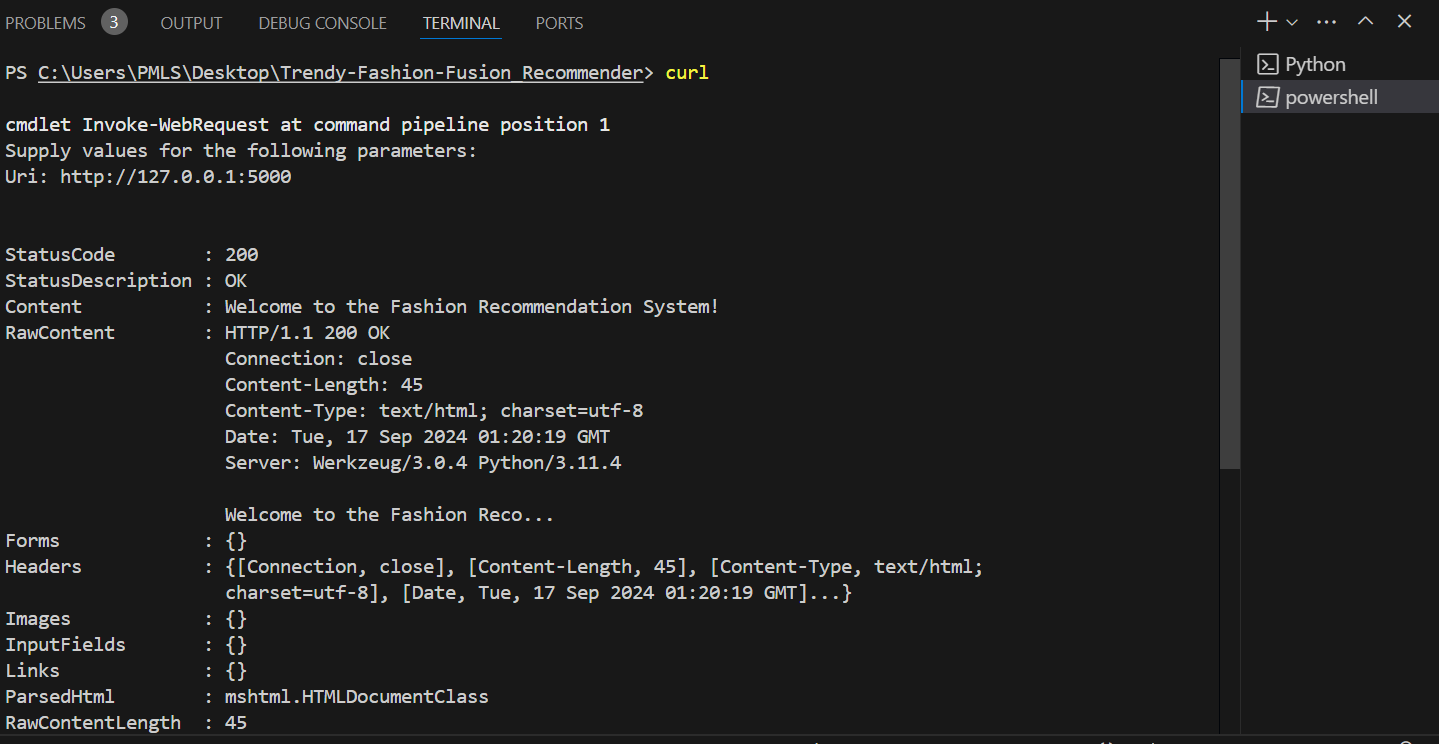

#### **File Upload Testing:**

To test the file upload feature, we'll need to make a POST request to `/upload` with a file. 


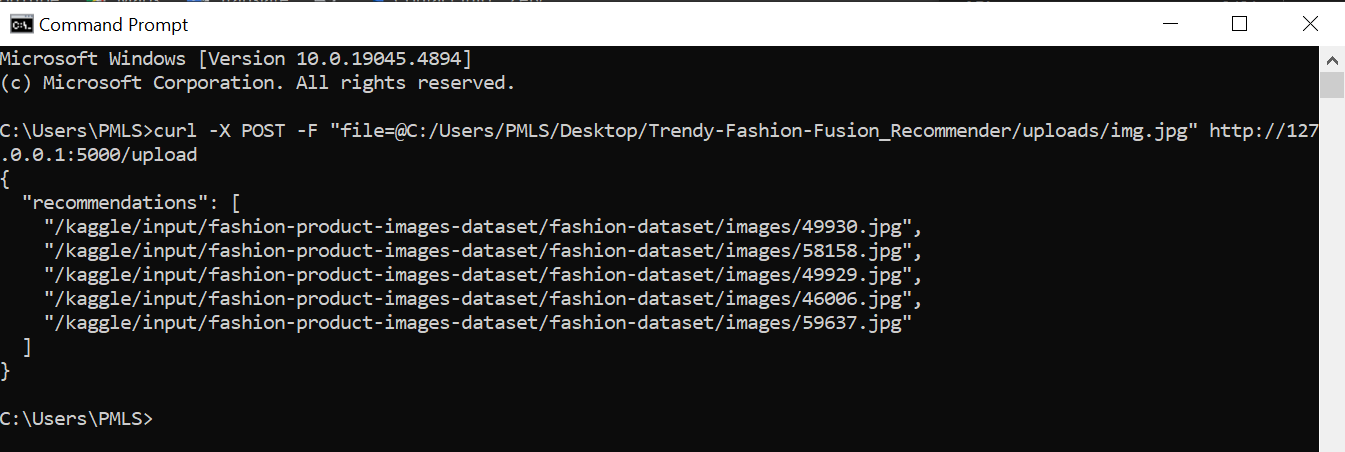

# Conclusion

This project summarized as:

1. **Define and Train/Load a Custom CNN**: Build a custom CNN architecture and train it or load pre-trained weights to extract features from images.
2. **Feature Extraction**: Use the custom CNN or pretrained to extract features  from both the images in your dataset and the query image.
3. **Compute Similarity**:  Use the extracted features to find similar images using a method like Nearest Neighbors or Cosine Similarity.
4. **Display Recommendations**: Show the query image and the recommended images.

### **Summary**

1. **Feature Extraction**: Extract features from images using a pre-trained model and flatten them.
2. **Nearest Neighbors**: Use Nearest Neighbors and another similarity measure named Cosine Similarity to find similar images. We fit the Nearest Neighbors model using the flattened features.
3. **Query and Visualization**: Find the nearest neighbors for any given image and visualize the results.

This approach helps you find and visualize similar images based on their feature representations, even in the absence of labels.

# **References**



# **Final Thoughts**

**This solution meets all the requirements:**

- Real-world problem: Fashion recommendation.
- Two models: ResNet50 for feature extraction and Nearest Neighbors for recommendations.
- Deployment using TensorFlow and Pickle files.
- API communication between models using Flask.

---
---